In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## 1. Problem Statement
Basic model to predict sold units (y) in terms of price (X)

In [1]:
# Exploratory data analysis
# Process data
# Build the model
# Train the model
# Evaluate the model
# Parameter tuning
# Prediction
# Deployment

In [3]:
# Read price data
path_file = '/home/stwpinillo/Documents/price-elasticity-rl/data/processed/data.csv'
data = pd.read_csv(path_file, index_col=0)

In [5]:
def process_data(df, product_id):
    """
    Process and modify the dataset by:
    - Converting 'date_id' to datetime and sorting by 'product_id' and 'date_id'
    - Adding month, day_of_week, value (sales / units), and price_per_unit
    - Filtering rows where product_id == 1
    - Adding previous_price, previous_units_sold columns
    - Adding time_step based on date_id

    Args:
    - df: The original DataFrame

    Returns:
    - A processed and modified DataFrame
    """

    df['date_id'] = pd.to_datetime(df['date_id'])
    df.sort_values(by=['product_id', 'date_id'], inplace=True)

    # Add time-based features
    df['month'] = df['date_id'].dt.month
    df['day'] = df['date_id'].dt.day
    df['day_of_week'] = df['date_id'].dt.dayofweek
    df['week_of_year'] = df['date_id'].dt.isocalendar().week
    df['is_weekend'] = df['date_id'].dt.dayofweek >= 5

    # Filter by product_id
    df_filtered = df[df['product_id'] == product_id].copy()
    # Drop unnecessary columns
    df_filtered.drop('category_id', axis=1, inplace=True)
    # Drop 'product_id' column as it is no longer needed
    df_filtered.drop('product_id', axis=1, inplace=True)
    # Add 'time_step' based on the ranking of 'date_id'
    df_filtered['time_step'] = df_filtered['date_id'].rank().astype(int)
    df_filtered['previous_units'] = df_filtered['units'].shift(1)
    df_filtered['previous_week_units'] = df_filtered['units'].shift(7)
    df_filtered['previous_price'] = df_filtered['price'].shift(1)
    df_filtered['previous_week_price'] = df_filtered['price'].shift(7)

    df_filtered.dropna(inplace=True)

    return df_filtered

data = process_data(data, 66)

In [6]:
data.head()

,date_id,sales,units,price,month,day,day_of_week,week_of_year,is_weekend,time_step,previous_units,previous_week_units,previous_price,previous_week_price
110455,2021-10-04,1624900.00,41,39631.71,10,4,0,40,False,8,71.0,25.0,40684.52,41860.00
109708,2021-10-05,3084700.00,73,42256.16,10,5,1,40,False,9,41.0,1279.0,39631.71,38707.19
109635,2021-10-06,3213001.00,76,42276.33,10,6,2,40,False,10,73.0,50.0,42256.16,41632.00
108943,2021-10-07,4243201.99,105,40411.45,10,7,3,40,False,11,76.0,76.0,42276.33,40038.17
108677,2021-10-08,4627100.00,114,40588.60,10,8,4,40,False,12,105.0,151.0,40411.45,41286.75


## 2. Exploratory Data Analysis

In [ ]:
# 2 missing days, which ones?

In [39]:
print(data.info())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 1222 entries, 110634 to 58111
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date_id  1222 non-null   datetime64[ns]
 1   sales    1222 non-null   float64       
 2   units    1222 non-null   int64         
 3   price    1222 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 47.7 KB
None
date_id    0
sales      0
units      0
price      0
dtype: int64


In [41]:
print(data.describe())


                             date_id         sales         units         price
count                           1222  1.222000e+03   1222.000000   1222.000000
mean   2023-06-01 11:05:47.626841088  2.346528e+07    587.261866  40620.966203
min              2021-09-27 00:00:00  1.407000e+05      3.000000  30301.790000
25%              2022-07-31 06:00:00  4.260575e+06    108.000000  37946.727500
50%              2023-06-01 12:00:00  8.519225e+06    211.000000  39199.235000
75%              2024-04-02 18:00:00  1.872126e+07    460.750000  43454.580000
max              2025-02-02 00:00:00  3.225706e+09  79923.000000  65866.410000
std                              NaN  1.192666e+08   3037.877335   3934.488044


<Axes: xlabel='date_id'>

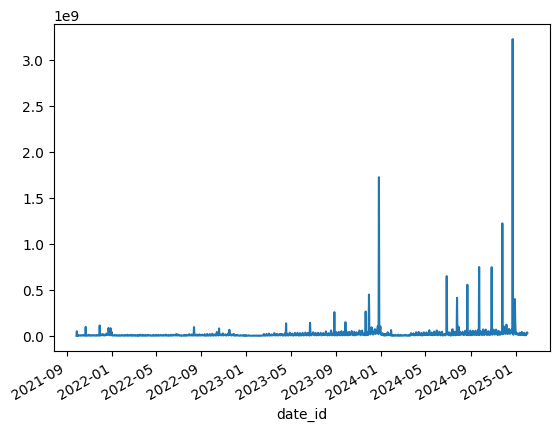

In [44]:
# Plot sales
data.groupby('date_id')['sales'].sum().plot()

<Axes: xlabel='date_id'>

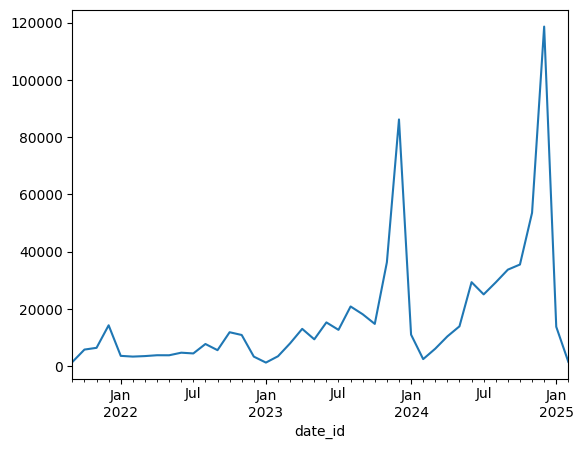

In [51]:
# Units sold by month
data.groupby(data['date_id'].dt.to_period('M'))['units'].sum().plot()

<Axes: xlabel='price', ylabel='units'>

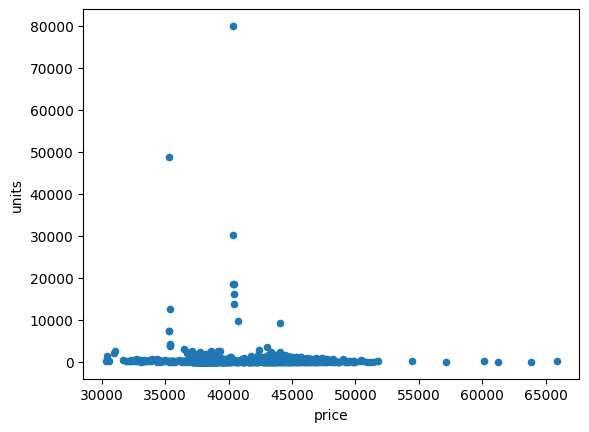

In [46]:
# Plot relationship between price and units
data.plot.scatter(x='price', y='units')


In [48]:
# Correlation matrix
print(data[['price', 'units', 'sales']].corr())


          price     units     sales
price  1.000000 -0.032644 -0.018795
units -0.032644  1.000000  0.998263
sales -0.018795  0.998263  1.000000


<Axes: >

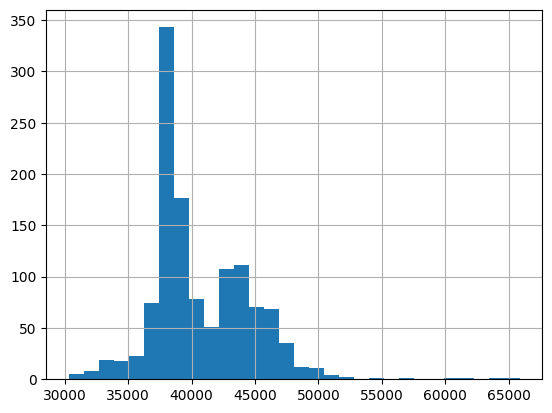

In [54]:
data['price'].hist(bins=30)


## 3. Data preprocessing

In [7]:
Q1 = data.units.quantile(0.25)
Q3 = data.units.quantile(0.75)
IQR = Q3 - Q1
outliers = (data.units < (Q1 - 1.5*IQR)) | (data.units > (Q3 + 1.5*IQR))

In [8]:
clean_data = data[~outliers]  # Keep only non-outliers

## 4. Model

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
# Define X (price) and y (units)
X = clean_data.drop(columns=['units'])
X = X.select_dtypes(exclude=['datetime64[ns]']) 
y = clean_data['units']

# Normalize (standardize) X using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use 80% of the data for training and 20% for testing
train_size = int(0.8 * len(data))  # 80% for training
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model on the scaled training data
model.fit(X_train, y_train)

# Predict using the test data
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Print some predictions for comparison
print("\nPredicted vs Actual (units):")
predicted_vs_actual = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predicted_vs_actual)


Mean Squared Error (MSE): 2031.5057107043206
R² Score: 0.9635720154570928

Predicted vs Actual (units):
        Actual   Predicted
64420      585  655.649749
103603     220  220.396560
104810     199  199.015238
104211     213  214.339355
91976      403  418.626056
...        ...         ...
105340     176  176.707429
100335     264  276.830666
82576      448  495.127343
43563      852  916.844793
58111      646  717.129799

[137 rows x 2 columns]
